# Overview

This project focuses on sentiment analysis. <br><br>
I'll use two datasets: one contains reviews collected from a e - commerce clothing website; the other is a set of Amazon reviews written by users who bought a musical instrument. <br><br>
Every review of both datasets is associated with a 1 - 5 scoring, which will be used to create the 3 target classes: positive (score equal to 4 or 5), neutral (score equal to 3), negative (score equal to 1 or 2). <br><br>
The objective is to create two models, one for each dataset: the first one will be trained from scratch on the texts of one of the datasets; the second model will be the result of fine - tuning the first model on the reviews of the second dataset.

# Set up

In [ ]:
install.packages("reticulate")
install.packages("text2vec")
install.packages("devtools")
devtools::install_github("rstudio/keras")
install.packages("iterators")
install.packages("yaml")
install.packages("foreach")
install.packages("R.utils")
install.packages("plyr")


library(reticulate)
library(text2vec)
library(devtools)
library(keras)
library(iterators)
library(yaml)
library(foreach)
library("R.utils")
library(plyr)

In [2]:
# Set random seed
set.seed(2)

In [3]:
# Download datasets, embeddings and trained models

# Datasets 
download.file("https://raw.githubusercontent.com/nicolapoggialini/text_mining/data/Womens%20Clothing%20E-Commerce%20Reviews.csv",
              "eCommerce.csv")
download.file("https://raw.githubusercontent.com/nicolapoggialini/text_mining/data/Musical_instruments_reviews.csv",
              "amazon_reviews.csv")

# Embeddings
download.file("https://github.com/nicolapoggialini/text_mining/raw/data/embeddings.RData",
              "embeddings.RData")


# Trained models
download.file("https://github.com/nicolapoggialini/text_mining/raw/data/biLSTM_model.h5",
              "biLSTM_model.h5")
download.file("https://github.com/nicolapoggialini/text_mining/raw/data/GRU_model.h5",
              "GRU_model.h5")
download.file("https://github.com/nicolapoggialini/text_mining/raw/data/biLSTM_FT_model.h5",
              "biLSTM_FT_model.h5")

# Clothing data

First of all, let's load the data and have a look at them.

In [4]:
clothing_data = read.csv(file = 'eCommerce.csv')

dim(clothing_data)
clothing_data[1,]

[1] 23486    11

,X,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,0,767,33,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates


Each instance of the clothing dataset presents 11 features, but the only ones needed for this task are the text of the review and the rating associated to it: in particular, I'm going to use the latter to define the classes.

In [5]:
# text review
cloth_reviews = clothing_data$Review.Text

# ratings
ratings = as.factor(clothing_data$Rating)
table(ratings)

# create classes
cloth_classes = mapvalues(ratings, from = c(1,2,3,4,5), to = c('Negative','Negative',
                                                                'Neutral','Positive','Positive'))
                                                                
message()
table(cloth_classes)

ratings
    1     2     3     4     5 
  842  1565  2871  5077 13131 

cloth_classes
Negative  Neutral Positive 
    2407     2871    18208 

The classes are quite unbalanced: the majority of the reviews are positive.

## Pre - processing

In [6]:
head(cloth_reviews)

[1] "Absolutely wonderful - silky and sexy and comfortable"                                                                                                                                                                                                                                                                                                                                                                                                                                                               
[2] "Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8\".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite."                                                                                                                                                                                                    
[3] "I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"
[4] "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"                                                                                                                                                                                                                                                                                                                                                                                        
[5] "This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!"                                                                                                                                                                                                                                                                                                                    
[6] "I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress."

We can observe that the texts are pretty clean, so only the conversion to lower case is needed for pre - processing.

In [7]:
# preprocessing
cloth_reviews = tolower(cloth_reviews)

# check
head(cloth_reviews)

[1] "absolutely wonderful - silky and sexy and comfortable"                                                                                                                                                                                                                                                                                                                                                                                                                                                               
[2] "love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8\".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite."                                                                                                                                                                                                    
[3] "i had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"
[4] "i love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"                                                                                                                                                                                                                                                                                                                                                                                        
[5] "this shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!"                                                                                                                                                                                                                                                                                                                    
[6] "i love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress."

## Split

In [8]:
# Defining a function for splitting the data

split_dataset = function(reviews, classes, train_perc) {
  
   "
    train_perc (double): percentage of the whole dataset used for the training set
  "

  # size of the train set
  train_size = floor(train_perc*length(reviews))

  # sampling indexes for train
  train_ind = sample(seq_len(length(reviews)), size = train_size)

  # train set
  train_reviews = reviews[train_ind]
  train_classes = classes[train_ind]

  # test set
  test_reviews = reviews[-train_ind]
  test_classes = classes[-train_ind]

  sets = list('train_reviews' = train_reviews, 'train_classes' = train_classes,
              'test_reviews' = test_reviews, 'test_classes' = test_classes)
  
  return(sets)

}


Now I'm going to do a train / validation / test split, in order to use the validation for testing different formulations of the model. <br>
Since the data don't have lots of instances, I'm going to take a big part of them for the train set, which will be used also to create the vocabulary and the embeddings.

In [9]:
train_perc = 0.9

sets = split_dataset(cloth_reviews, cloth_classes, train_perc)

In [10]:
# train
train_reviews = sets$train_reviews
train_classes = sets$train_classes

# val + test
val_test_reviews = sets$test_reviews
val_test_classes = sets$test_classes

val_perc = 0.5
sets_val_test = split_dataset(val_test_reviews, val_test_classes, val_perc)

# validation
val_reviews = sets_val_test$train_reviews
val_classes = sets_val_test$train_classes

# test
test_reviews = sets_val_test$test_reviews
test_classes = sets_val_test$test_classes

message('Number of instances for train: ', length(train_reviews))
message('Number of instances for validation: ', length(val_reviews))
message('Number of instances for test: ', length(test_reviews))

# remove val + test set
rm(val_test_reviews)
rm(val_test_classes)

Number of instances for train: 21137

Number of instances for validation: 1174

Number of instances for test: 1175



## Tokenization and Embeddings

In [11]:
# tokenization
train_tokens = word_tokenizer(train_reviews)

# iterator over tokens
train_iter = itoken(train_tokens)

In [12]:
# vocabulary
vocab = create_vocabulary(train_iter)

message('Number of terms in the vocabulary: ', length(vocab$term))

Number of terms in the vocabulary: 14215



In [13]:
# deleting from the vocabulary the terms that appear less than 5 times
vocab = prune_vocabulary(vocab, term_count_min = 5)
vocab_size = length(vocab$term)

message('Number of terms in the pruned vocabulary: ', vocab_size)

Number of terms in the pruned vocabulary: 4850



In [14]:
# embeddings

embedding_dim = 50

In [15]:
# Load the computed embeddings
# if run, skip to "Properties of Embeddings" section

word_vectors = get(load('embeddings.RData'))

#check
dim(word_vectors)

[1] 4850   50

In [16]:
# one hot encoding
vect = vocab_vectorizer(vocab)

# term-term co-occurency matrix
train_occ_mat = create_tcm(train_iter, vect, skip_grams_window = 5)

In [17]:
# initialize and fit the glove model

glove_model = GlobalVectors$new(rank = embedding_dim, x_max = 10)
embeddings = glove_model$fit_transform(train_occ_mat, n_iter = 20, n_threads = 8)

INFO  [16:16:32.259] epoch 1, loss 0.2554 
INFO  [16:16:33.202] epoch 2, loss 0.1480 
INFO  [16:16:34.091] epoch 3, loss 0.1232 
INFO  [16:16:34.981] epoch 4, loss 0.1086 
INFO  [16:16:35.873] epoch 5, loss 0.0991 
INFO  [16:16:36.769] epoch 6, loss 0.0924 
INFO  [16:16:37.665] epoch 7, loss 0.0874 
INFO  [16:16:38.560] epoch 8, loss 0.0836 
INFO  [16:16:39.437] epoch 9, loss 0.0806 
INFO  [16:16:40.313] epoch 10, loss 0.0781 
INFO  [16:16:41.202] epoch 11, loss 0.0761 
INFO  [16:16:42.102] epoch 12, loss 0.0744 
INFO  [16:16:42.972] epoch 13, loss 0.0729 
INFO  [16:16:43.848] epoch 14, loss 0.0717 
INFO  [16:16:44.729] epoch 15, loss 0.0705 
INFO  [16:16:45.659] epoch 16, loss 0.0695 
INFO  [16:16:46.568] epoch 17, loss 0.0687 
INFO  [16:16:47.507] epoch 18, loss 0.0679 
INFO  [16:16:48.385] epoch 19, loss 0.0672 
INFO  [16:16:49.272] epoch 20, loss 0.0665 


In [18]:
# context word vectors
context = glove_model$components

word_vectors = embeddings + t(context)

In [19]:
# save embeddings
save(word_vectors, file = "embeddings.RData")

### Properties of Embeddings

In this section, I'll look at a couple of examples to have an idea of whether the embeddings represent effectively the meaning of the words.

In [32]:
# Function to print the n most similar terms to a given term, except the term itself

similar_words <- function(v, n = 10) {

  result = head(sort(sim2(word_vectors, matrix(v, 1, ncol(word_vectors)), 
                            method = "cosine", norm = "l2")[,1], 
                                decreasing = T), n)
  print(result[result<0.9999])
  
}

In [33]:
similar_words(word_vectors['sweater',])

    shirt      coat     dress    jacket      this  cardigan       top    blouse 
0.8330333 0.8135503 0.8062741 0.7945737 0.7814032 0.7721861 0.7597939 0.7540357 
     it's 
0.7394417 


In [34]:
# winter : cold = x : hot

similar_words(word_vectors['winter',] - word_vectors['cold',] + word_vectors['hot',])

   summer       hot    spring    winter      fall       new    staple       for 
0.7335912 0.6945564 0.6723211 0.6544933 0.6293984 0.5792345 0.5692780 0.5619233 
 favorite      days 
0.5508059 0.5499682 


## Input

In this section, I'm preparing the data to pass them as input to the model: in particular, I'll replace every term with its index in the vocabulary and pad the sequences to a fixed length.

In [20]:
# assign to each token its index in the vocabulary
train_indexes = lapply(train_tokens, match, vocab$term)

# since we removed unfrequent words, we're going to have some out of vocabulary words:
# these generate an NA, so i'm removing them

train_indexes_ = lapply(train_indexes, function(s) array(s[!is.na(s), drop = F] - 1))

In [21]:
# max length of input sequences
max_length = 200

In [22]:
# padding
train_X = pad_sequences(train_indexes_, maxlen = max_length)

In [23]:
# targets
train_Y = to_categorical(as.numeric(train_classes) - 1)

In [24]:
# Defining a function to speed up the preparation of input

prepare_input = function(texts, classes, max_len){

  " 
  max_len (int): max length of the padded sequences
  "
  
  # tokenization
  tokens = word_tokenizer(texts)
  
  # tokens' indexes
  indexes = lapply(tokens, match, vocab$term)

  # remove NA
  indexes = lapply(indexes, function(s) array(s[!is.na(s), drop = F] - 1))

  # padding
  indexes = pad_sequences(indexes, maxlen = max_len)

  # target preparation
  targets = to_categorical(as.numeric(classes) - 1)

  data = list('X' = indexes, 'Y' = targets)

  return(data)

}

## Models

Now I'm going to define two models that share the same architecture except for the recurrent module:

- Embedding layer
- Recurrent layer (biLSTM or GRU)
- Dense layer

I'm going to train both and I'll proceed with the one that produces the best results on the validation set.

In [25]:
# Setting the number of units for the recurrent module
recurrent_units = 64

In [26]:
# Defining the model with the bidirectional LSTM

biLSTM_model = keras_model_sequential()

biLSTM_model %>% layer_embedding(input_dim = vocab_size, output_dim = embedding_dim,
                        input_length = max_length, trainable = FALSE, weights = list(word_vectors))

biLSTM_model %>% bidirectional(layer_lstm(units = recurrent_units, dropout = 0.5))
biLSTM_model %>% layer_dense(units = 3, activation = "softmax")

In [27]:
# Defining the model with the GRU

GRU_model = keras_model_sequential()

GRU_model %>% layer_embedding(input_dim = vocab_size, output_dim = embedding_dim,
                        input_length = max_length, trainable = FALSE, weights = list(word_vectors))

GRU_model %>% layer_gru(units = recurrent_units, dropout = 0.5)
GRU_model %>% layer_dense(units = 3, activation="softmax")

### Training

biLSTM

In [ ]:
# compile
biLSTM_model %>% keras::compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

In [ ]:
# fit
biLSTM_train_hist = biLSTM_model %>% keras::fit(train_X, train_Y, epochs = 20, batch_size = 256)

`geom_smooth()` using formula 'y ~ x'



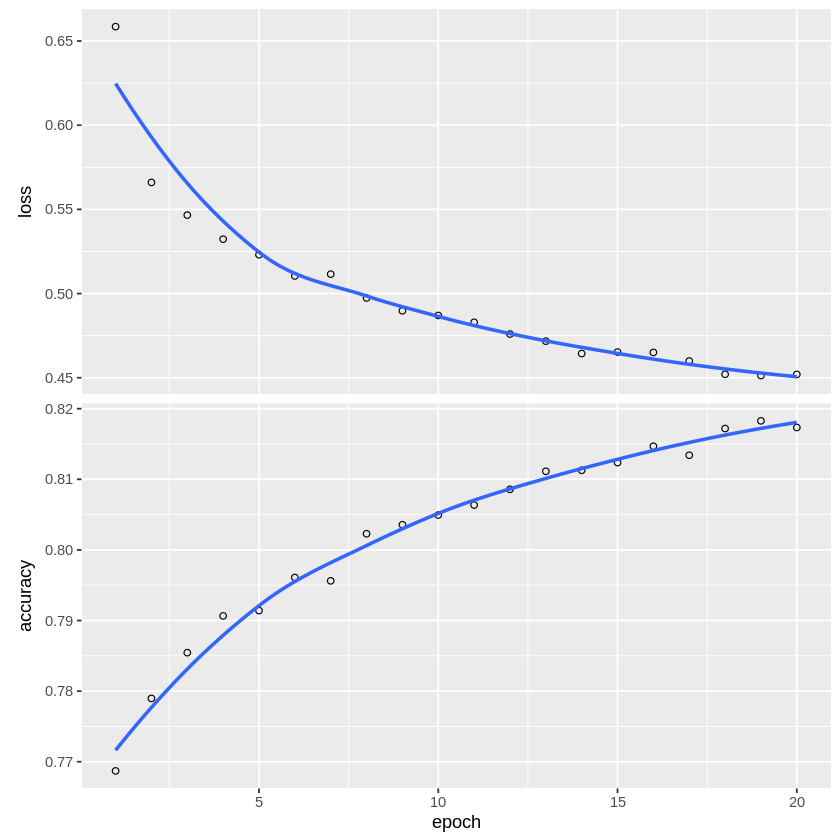

In [ ]:
# plot training 
plot(biLSTM_train_hist, type = "b")

In [ ]:
# save model and weights

save_model_hdf5(biLSTM_model, "biLSTM_model.h5") 
save_model_weights_hdf5(biLSTM_model, "biLSTM_weights.h5")

GRU

In [ ]:
# compile
GRU_model %>% keras::compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

In [ ]:
# fit
GRU_train_hist = GRU_model %>% keras::fit(train_X, train_Y, epochs = 20, batch_size = 256)

`geom_smooth()` using formula 'y ~ x'



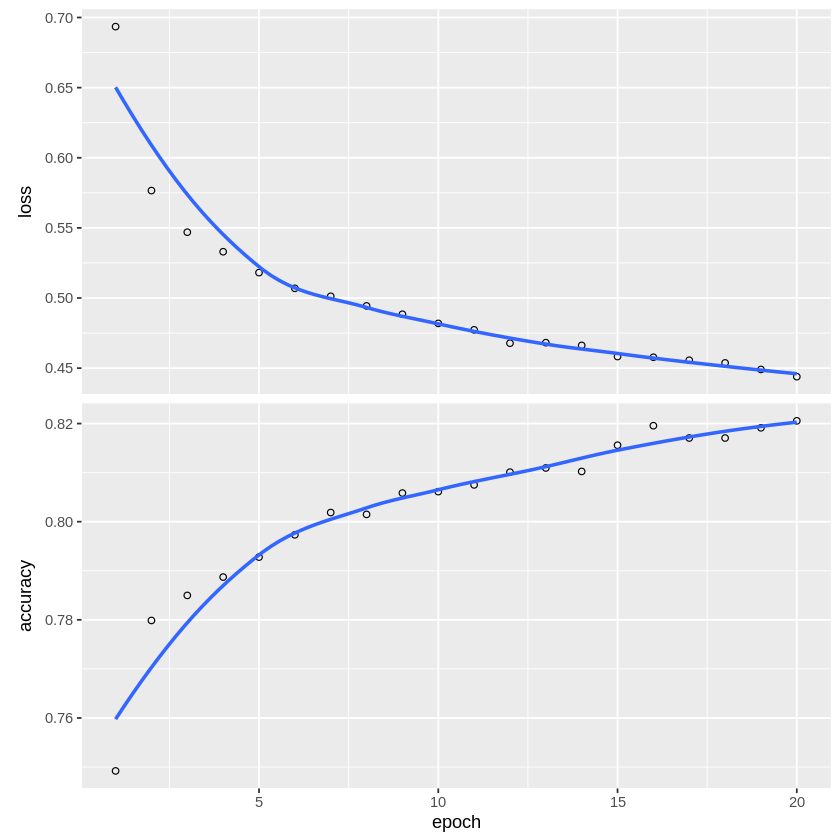

In [ ]:
# plot training
plot(GRU_train_hist, type = "b")

In [ ]:
# save model and weights

save_model_hdf5(GRU_model, "GRU_model.h5") 
save_model_weights_hdf5(GRU_model, "GRU_weights.h5")

### Evaluation

In [28]:
# Load trained models

biLSTM_model = load_model_hdf5('biLSTM_model.h5')
GRU_model = load_model_hdf5('GRU_model.h5')

Validation

In [29]:
val = prepare_input(val_reviews, val_classes, max_length)

biLSTM_val = keras::evaluate(biLSTM_model, val$X, val$Y, batch_size = 100)

GRU_val = keras::evaluate(GRU_model, val$X, val$Y, batch_size = 100)

In [30]:
b_val_acc = biLSTM_val[[2]] # biLSTM model accuracy on validation
g_val_acc = GRU_val[[2]] # GRU model accuracy on validation

message('Accuracy on the validation set')
message()
message('biLSTM: ', b_val_acc)
message('GRU: ', g_val_acc)

Accuracy on the validation set



biLSTM: 0.812606453895569

GRU: 0.798126041889191



In [31]:
compare_models = function(acc1, acc2, n1, n2, conf) {

  "
  Function to compare the results of two models

  acc1 (double): accuracy of the first model
  acc2 (double): accuracy of the second model
  n1 (int): number of instances used to compute the first accuracy
  n2 (int): number of instances used to compute the second accuracy
  conf (double): confidence
  "

  # difference
  d = abs(acc1 - acc2)

  # standard deviation of the difference
  sigma1 = ( acc1 * (1 - acc1) ) / n1
  sigma2 = ( acc2 * (1 - acc2) ) / n2
  sigma_d = sqrt(sigma1 + sigma2)

  # find Z
  q = conf + (1 - conf)/2
  Z = qnorm(q)

  # confidence interval
  pmax = d + Z*sigma_d
  pmin = d - Z*sigma_d

  # check if the interval contains the zero
  if(pmin <= 0 & pmax >= 0) {

    message('The difference is not statically significant')

  } else {

    message('The difference is statistically significant')

  }

}

In [32]:
val_N = length(val_reviews)
confidence = 0.95

compare_models(b_val_acc, g_val_acc, val_N, val_N, confidence)

The difference is not statically significant



I can conclude that the difference between the results on the validation set is given by chance: the models present basically the same performance and I can go on with one or the other. <br>
I'll procede with the model that uses the biLSTM.

Test

In [33]:
test = prepare_input(test_reviews, test_classes, max_length)

biLSTM_test = keras::evaluate(biLSTM_model, test$X, test$Y, batch_size = 100)
test_acc = biLSTM_test[[2]]

message('Accuracy on the test set: ', test_acc)

Accuracy on the test set: 0.826382994651794



In [34]:
confidence_interval = function(acc, N, conf) {

  "
  Function to compute and print the confidence interval

  acc (double): accuracy
  N (int): number of instances used to compute the accuracy
  conf (double): confidence
  "

  # find Z
  q = conf + (1 - conf)/2
  Z = qnorm(q)

  # compute extremes of the interval
  t1 = 2 * N * acc + Z**2
  t2 = Z**2 + 4 * N * acc - 4 * N * acc**2
  t3 = Z * sqrt(t2)
  d = 2*(N + Z**2)

  p_max = (t1 + t3) / d
  p_min = (t1 - t3) / d

  message('Confidence interval of accuracy: [', p_min, ' , ' , p_max, ']')

}

In [35]:
test_N = length(test_reviews)
confidence = 0.95

confidence_interval(test_acc, test_N, confidence)

Confidence interval of accuracy: [0.803670712542907 , 0.846968125862912]



# Musical instruments data

In [36]:
amazon_data <- read.csv(file = 'amazon_reviews.csv')

# check
dim(amazon_data)
amazon_data[1,]

[1] 10261     9

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
1,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",5,good,1393545600,"02 28, 2014"


In [37]:
# text review
music_reviews = amazon_data$reviewText

# scores
scores = as.factor(amazon_data$overall)
table(scores)

music_classes = mapvalues(scores, from = c(1,2,3,4,5), to = c('Negative','Negative',
                                                                'Neutral','Positive','Positive'))
                                                                
message()
table(music_classes)

scores
   1    2    3    4    5 
 217  250  772 2084 6938 

music_classes
Negative  Neutral Positive 
     467      772     9022 

Like we observed for the first dataset, we still have the majority of reviews classiefied as positive.

## Pre - processing

In [38]:
head(music_reviews)

[1] "Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,"                                                                                                                                                                                                                                                                                    
[2] "The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]"
[3] "The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it."                                                                                                            
[4] "Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging."                                                                                                                                                                                                                                                                                                                                                  
[5] "This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing."                                                                                                                                                                                                                                                                                                                                                                                                 
[6] "So good that I bought another one.  Love the heavy cord and gold connectors.  Bass sounds great.  I just learned last night how to coil them up.  I guess I should read instructions more carefully.  But no harm done, still works great!"

Again, given the good quality of the text, I'm just going to use the lower case for pre - processing.

In [39]:
# pre - processing
music_reviews = tolower(music_reviews)

# check
head(music_reviews)

[1] "not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,"                                                                                                                                                                                                                                                                                    
[2] "the product does exactly as it should and is quite affordable.i did not realized it was double screened until it arrived, so it was even better than i had expected.as an added bonus, one of the screens carries a small hint of the smell of an old grape candy i used to buy, so for reminiscent's sake, i cannot stop putting the pop filter next to my nose and smelling it after recording. :dif you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!buy this product! :]"
[3] "the primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. the double cloth filter blocks the pops and lets the voice through with no coloration. the metal clamp mount attaches to the mike stand secure enough to keep it attached. the goose neck needs a little coaxing to stay where you put it."                                                                                                            
[4] "nice windscreen protects my mxl mic and prevents pops. only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging."                                                                                                                                                                                                                                                                                                                                                  
[5] "this pop filter is great. it looks and performs like a studio filter. if you're recording vocals this will eliminate the pops that gets recorded when you sing."                                                                                                                                                                                                                                                                                                                                                                                                 
[6] "so good that i bought another one.  love the heavy cord and gold connectors.  bass sounds great.  i just learned last night how to coil them up.  i guess i should read instructions more carefully.  but no harm done, still works great!"

## Split

Now I'm going to split the data in train, validation and test: in this case, the validation will be used to test the model with and without fine - tuning. Since the vocabulary is already built, I'll use a smaller portion for traning with respect to the one used for the clothing dataset.

In [40]:
train_perc = 0.7

sets = split_dataset(music_reviews, music_classes, train_perc)

In [41]:
# train
music_train_rev = sets$train_reviews
music_train_class = sets$train_classes

# val + test
val_test_rev = sets$test_reviews
val_test_class = sets$test_classes

val_perc = 0.5
sets_val_test = split_dataset(val_test_rev, val_test_class, val_perc)

# validation
music_val_rev = sets_val_test$train_reviews
music_val_class = sets_val_test$train_classes

# test
music_test_rev = sets_val_test$test_reviews
music_test_class = sets_val_test$test_classes

message('Number of instances for train: ', length(music_train_rev))
message('Number of instances for validation: ', length(music_val_rev))
message('Number of instances for test: ', length(music_test_rev))

# remove val + test set
rm(val_test_rev)
rm(val_test_class)

Number of instances for train: 7182

Number of instances for validation: 1539

Number of instances for test: 1540



## Models

### Fine - tuning

In [42]:
# create input

music_train = prepare_input(music_train_rev, music_train_class, max_length)

In [43]:
# load model trained on the clothing dataset
biLSTM_model_FT = load_model_hdf5('biLSTM_model.h5')

In [ ]:
# fine tuning
biLSTM_ft_hist = biLSTM_model_FT %>% keras::fit(music_train$X, music_train$Y, epochs = 10, batch_size = 256)

`geom_smooth()` using formula 'y ~ x'



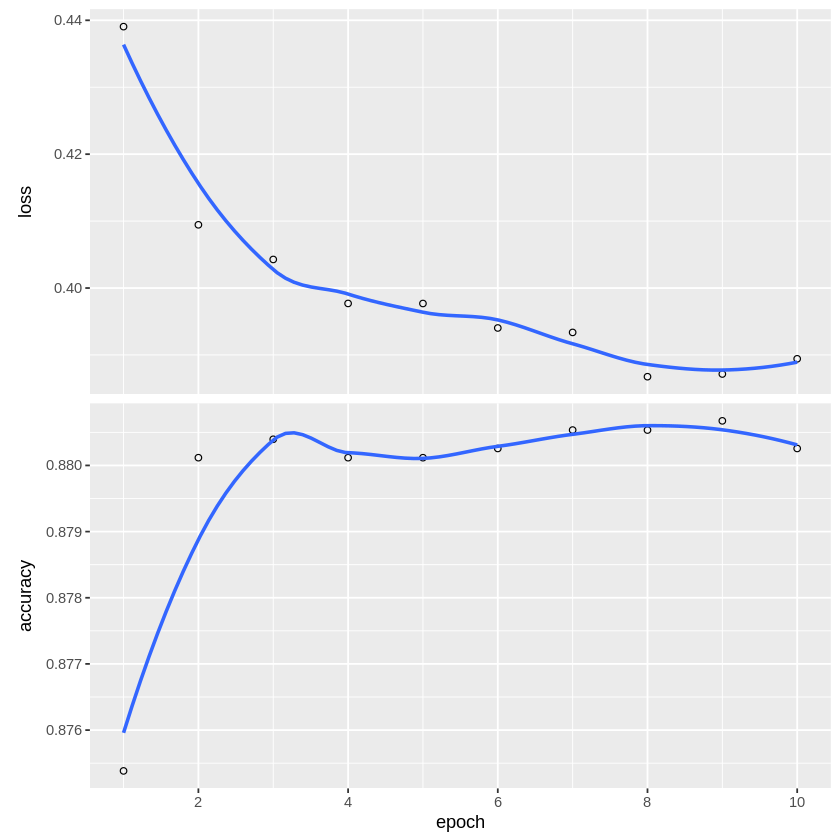

In [ ]:
# plot fine tuning
plot(biLSTM_ft_hist, type = "b")

In [ ]:
# save model and weights

save_model_hdf5(biLSTM_model_FT, "biLSTM_FT_model.h5") 
save_model_weights_hdf5(biLSTM_model_FT, "biLSTM_FT_weights.h5")

### Evaluation

Validation

In [44]:
# load model without fine tuning
biLSTM_model_ = load_model_hdf5('biLSTM_model.h5')

# load model with fine tuning
biLSTM_model_FT = load_model_hdf5('biLSTM_FT_model.h5')

In [45]:
music_val = prepare_input(music_val_rev, music_val_class, max_length)

FT_val = keras::evaluate(biLSTM_model_FT, music_val$X, music_val$Y, batch_size = 100)

no_FT_val = keras::evaluate(biLSTM_model_, music_val$X, music_val$Y, batch_size = 100)

In [46]:
FT_val_acc = FT_val[[2]]
no_FT_val_acc = no_FT_val[[2]]

message('Accuracy on the validation set')
message()
message('With fine - tuning: ', FT_val[[2]])
message('Without fine - tuning: ', no_FT_val[[2]])

Accuracy on the validation set



With fine - tuning: 0.881091594696045

Without fine - tuning: 0.719947993755341



In [47]:
music_val_N = length(music_val_rev)
confidence = 0.95

compare_models(FT_val_acc, no_FT_val_acc, music_val_N, music_val_N, confidence)

The difference is statistically significant



The statistical test confirms that the model performs better after fine - tuning.

Test

In [48]:
music_test = prepare_input(music_test_rev, music_test_class, max_length)

biLSTM_FT_test = keras::evaluate(biLSTM_model_FT, music_test$X, music_test$Y, batch_size = 100)
music_test_acc = biLSTM_FT_test[[2]]

message('Accuracy on the test set: ', music_test_acc)

Accuracy on the test set: 0.883766233921051



In [49]:
music_test_N = length(music_test_rev)
confidence = 0.95

confidence_interval(music_test_acc, music_test_N, confidence)

Confidence interval of accuracy: [0.866795298496084 , 0.89882735901419]



# Final comparison of the models

In conclusion, I'm going to do a statistical test to compare the performance of the chosen models on the respective test sets:
- Clothing data / biLSTM: accuracy = 0.83
- Musical instruments data / biLSTM with fine tuning: accuracy = 0.88

In [50]:
compare_models(music_test_acc, test_acc, music_test_N, test_N, confidence)

The difference is statistically significant



The results show that the model with fine - tuning performs better on the musical instruments reviews with respect to the base model on the clothing reviews.